In [1]:
mode="local"
if mode == "SUBMIT":
    deps_path = '/kaggle/input/czii-cryoet-dependencies'
    ! cp -r /kaggle/input/czii-cryoet-dependencies/asciitree-0.3.3/ asciitree-0.3.3/
    ! pip wheel asciitree-0.3.3/asciitree-0.3.3/
    ! pip install asciitree-0.3.3-py3-none-any.whl
    ! pip install -q --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt
else:
    !pip install monai
    !pip install lightning
    !pip install connected-components-3d copick
    !pip install pickle
    !pip install zarr
    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 18.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━

In [4]:
import lightning.pytorch as pl
from typing import Tuple, List, Dict, Union
from monai.networks.nets import UNet
from monai.losses import TverskyLoss
from monai.metrics import DiceMetric
import numpy as np
class Model(pl.LightningModule):
    def __init__(
        self, 
        spatial_dims: int = 3,
        in_channels: int = 1,
        out_channels: int = 7,
        channels: Union[Tuple[int, ...], List[int]] = (48, 64, 80, 80),
        strides: Union[Tuple[int, ...], List[int]] = (2, 2, 1),
        num_res_units: int = 1,
        lr: float=1e-3):
    
        super().__init__()
        self.save_hyperparameters()
        self.model = UNet(
            spatial_dims=self.hparams.spatial_dims,
            in_channels=self.hparams.in_channels,
            out_channels=self.hparams.out_channels,
            channels=self.hparams.channels,
            strides=self.hparams.strides,
            num_res_units=self.hparams.num_res_units,
        )
        self.loss_fn = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
        self.metric_fn = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)

        self.train_loss = 0
        self.val_metric = 0
        self.num_train_batch = 0
        self.num_val_batch = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.train_loss += loss
        self.num_train_batch += 1
        torch.cuda.empty_cache()
        return loss

    def on_train_epoch_end(self):
        loss_per_epoch = self.train_loss/self.num_train_batch
        print(f"Epoch {self.current_epoch} - Average Train Loss: {loss_per_epoch:.4f}")
        self.log('train_loss', loss_per_epoch, prog_bar=True)
        self.train_loss = 0
        self.num_train_batch = 0
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad(): # This ensures that gradients are not stored in memory
            x, y = batch['image'], batch['label']
            y_hat = self(x)
            metric_val_outputs = [AsDiscrete(argmax=True, to_onehot=self.hparams.out_channels)(i) for i in decollate_batch(y_hat)]
            metric_val_labels = [AsDiscrete(to_onehot=self.hparams.out_channels)(i) for i in decollate_batch(y)]

            # compute metric for current iteration
            self.metric_fn(y_pred=metric_val_outputs, y=metric_val_labels)
            metrics = self.metric_fn.aggregate(reduction="mean_batch")
            val_metric = torch.mean(metrics) # I used mean over all particle species as the metric. This can be explored.
            self.val_metric += val_metric 
            self.num_val_batch += 1
        torch.cuda.empty_cache()
        return {'val_metric': val_metric}

    def on_validation_epoch_end(self):
        metric_per_epoch = self.val_metric/self.num_val_batch
        print(f"Epoch {self.current_epoch} - Average Val Metric: {metric_per_epoch:.4f}")
        self.log('val_metric', metric_per_epoch, prog_bar=True, sync_dist=False) # sync_dist=True for distributed training
        self.val_metric = 0
        self.num_val_batch = 0
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


channels = (48, 64, 80, 80)
strides_pattern = (2, 2, 1)       
num_res_units = 1
learning_rate = 1e-4
num_epochs = 50

model = Model(spatial_dims=3, in_channels=1, out_channels=7, channels=channels, strides=strides_pattern, num_res_units=num_res_units, lr=learning_rate)


In [5]:
import torch
model = torch.load("/kaggle/input/3dunet-training/model.pth")
model.eval()

/tmp/ipykernel_30/6545134.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/input/3dunet-training/model.pth")


Model(
  (model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 48, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): InstanceNorm3d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(1, 48, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        (submodule): Sequential(
          (0): ResidualUnit(
            (conv): Sequential(
              (unit0): Convolution(
                (conv): Conv3d(48, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
                (adn): ADN(
                  (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                  (D):

In [6]:
def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with minimal overlap to cover the entire dimension.
    
    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension
        
    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]
        
    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)
    
    if n_patches == 1:
        return [0]
    
    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)

    print(total_overlap)
    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)
    
    return positions

def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with minimal overlap to cover the entire array.
    
    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)
        
    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")
    
    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")
    
    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")
    
    m, n, l = shape
    patches = []
    coordinates = []
    
    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)
    
    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))
    
    return patches, coordinates

# Note: I should probably averge the overlapping areas, 
# but here they are just overwritten by the most recent one. 

def reconstruct_array(patches: List[np.ndarray], 
                     coordinates: List[Tuple[int, int, int]], 
                     original_shape: Tuple[int, int, int]) -> np.ndarray:
    """
    Reconstruct array from patches.
    
    Parameters:
    -----------
    patches : List[np.ndarray]
        List of patches to reconstruct from
    coordinates : List[Tuple[int, int, int]]
        Starting coordinates for each patch
    original_shape : Tuple[int, int, int]
        Shape of the original array
        
    Returns:
    --------
    np.ndarray
        Reconstructed array
    """
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions
    
    patch_size = patches[0].shape[0]
    
    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch
        
    
    return reconstructed


In [7]:
import pandas as pd

def dict_to_df(coord_dict, experiment_name):
    """
    Convert dictionary of coordinates to pandas DataFrame.
    
    Parameters:
    -----------
    coord_dict : dict
        Dictionary where keys are labels and values are Nx3 coordinate arrays
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['x', 'y', 'z', 'label']
    """
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    
    return df

In [8]:
#Iterate over all train experiments and normalize using percentile 0.15 and 98. Then crop values from 0 to 1 and feed them into our model.
train_data = []
train_experiment_names = ['TS_5_4', 'TS_69_2', 'TS_6_6','TS_73_6', 'TS_86_3',"TS_99_9" ]
valid_experiment_names = ['TS_6_4']
TRAIN_DIR = "/kaggle/input/dataset-cryoet/"

for name in train_experiment_names:
    image = np.load(TRAIN_DIR + f"train_image_{name}.npy")
    label = np.load(TRAIN_DIR + f"train_label_{name}.npy")
    mean = image.flatten().mean()
    std = image.flatten().std()
    print(mean, std)
    min_value = np.percentile(image.flatten(), 0.15)
    max_value = np.percentile(image.flatten(), 98)
    image = (image - min_value) / (max_value - min_value)    
    image = np.clip(image, 0, 1)
    train_data.append({"image": image, "label": label})
    
val_data = []
for name in valid_experiment_names:
    image = np.load(TRAIN_DIR + f"train_image_{name}.npy")
    label = np.load(TRAIN_DIR + f"train_label_{name}.npy")
    min_value = np.percentile(image.flatten(), 0.15)
    max_value = np.percentile(image.flatten(), 98)
    image = (image - min_value) / (max_value - min_value)
    image = (image - min_value) / (max_value - min_value)    
    image = np.clip(image, 0, 1)
    val_data.append({"image": image, "label": label})
    print(np.unique(label))

2.06502e-07 7.438237e-06
3.2555099e-07 6.791437e-06
1.4182532e-07 6.4576284e-06
-5.5547197e-08 7.043796e-06
1.2052784e-07 6.599121e-06
-3.9140807e-07 8.024839e-06
[0 1 2 3 4 5 6]


In [9]:
image1 = train_data[0]["image"]
label1 = train_data[0]["label"]
print(image1.shape,label1.shape)

patches_image, coordinates_image  = extract_3d_patches_minimal_overlap([image1],96)
label_image, coordinates_label = extract_3d_patches_minimal_overlap([label1],96)


(184, 630, 630) (184, 630, 630)
8.0
7.0
7.0
8.0
7.0
7.0


In [10]:
for i in range(len(patches_image)):
    patches_image[i] = np.expand_dims(patches_image[i], axis=0)

print(patches_image[0].shape)
batch_of_images = np.array(patches_image)
print(batch_of_images.shape)

(1, 96, 96, 96)
(98, 1, 96, 96, 96)


In [12]:
import torch
import gc

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device and set to evaluation mode
model = model.to(device)
model.eval()

# Batch size
batch_size = 10  # Adjust based on GPU memory

# Store predictions
all_predictions = []

# Disable gradients for inference
with torch.no_grad():
    for i in range(0, len(batch_of_images), batch_size):
        # Slice the batch
        batch = batch_of_images[i:i + batch_size]

        # Convert batch to tensor and move to GPU
        input_tensor = torch.from_numpy(batch).float().to(device)

        # Make predictions
        predictions = model(input_tensor)

        # Store predictions (move them to CPU to save GPU memory)
        all_predictions.append(predictions.cpu())

        # Clear GPU cache
        torch.cuda.empty_cache()
        gc.collect()

# Combine all predictions into a single tensor if needed
final_predictions = torch.cat(all_predictions)


In [13]:
import torch.nn.functional as F
probabilities = F.softmax(final_predictions, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)
print(predicted_classes.shape)

torch.Size([98, 96, 96, 96])


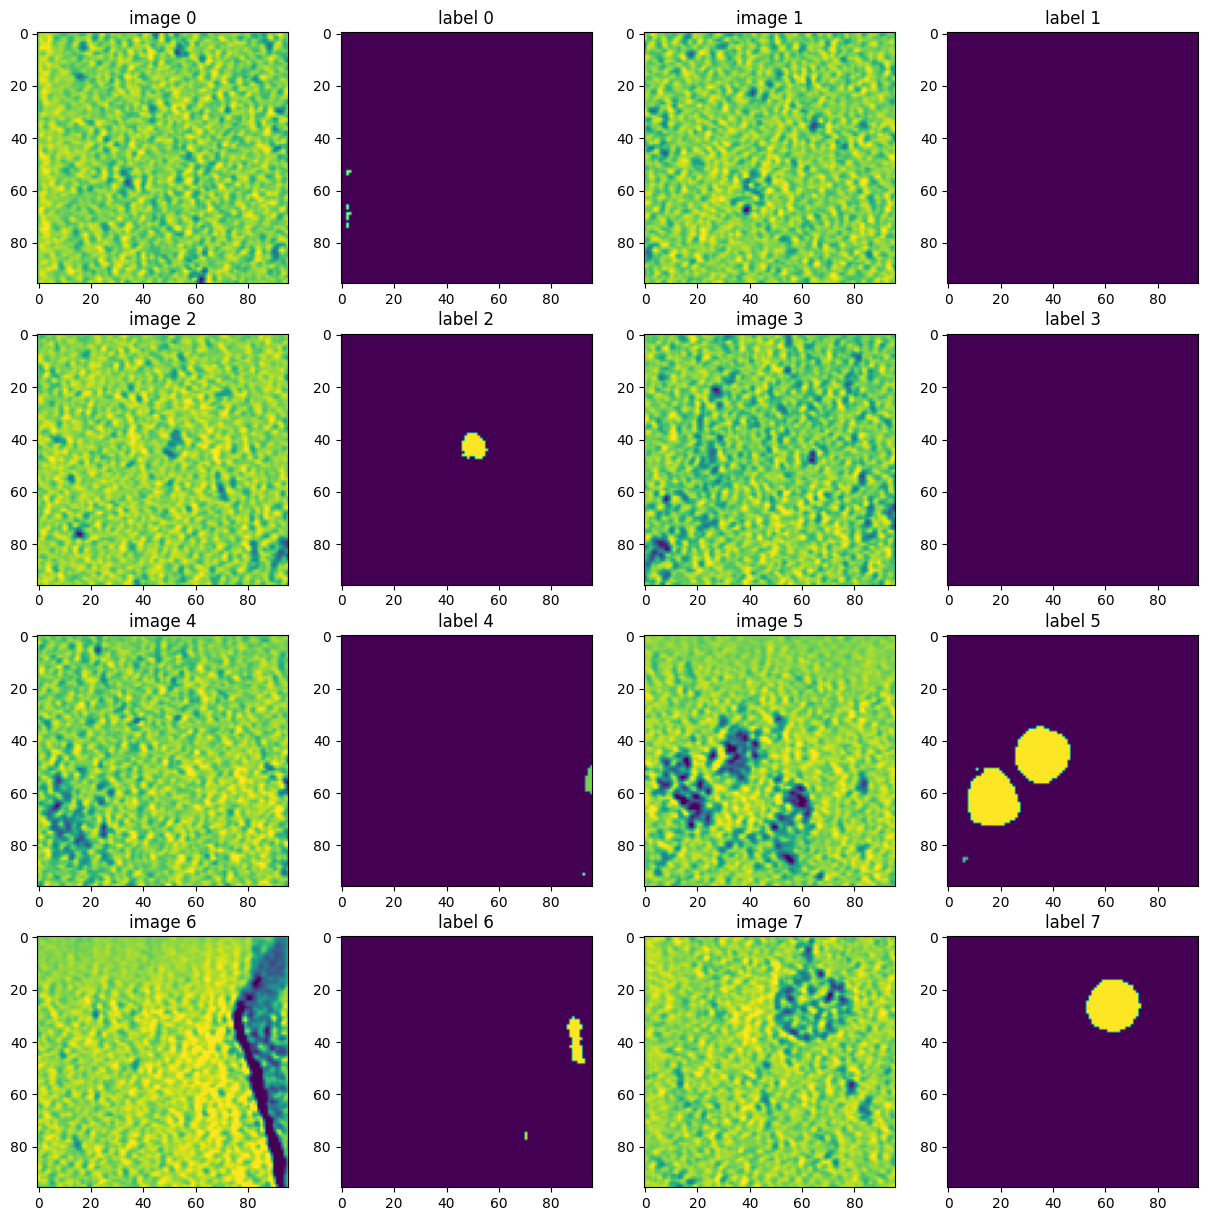

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4,4,figsize=(15,15))
axes = axes.flatten()
for i in range (len(axes)//2):
    axes[i*2].imshow(patches_image[i][0,60,:,:])
    axes[i*2+1].imshow(predicted_classes[i][60,:,:])
    axes[i*2].set_title(f"image {i}")
    axes[i*2+1].set_title(f"label {i}")
    

In [ ]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(4,4,figsize=(15,15))
axes = axes.flatten()
for i in range (len(axes)//2):
    axes[i*2].imshow(patches_image[i][0,60,:,:])
    axes[i*2+1].imshow(label_image[i][60,:,:])
    axes[i*2].set_title(f"image {i}")
    axes[i*2+1].set_title(f"label {i}")    
        
plt.tight_layout()
plt.show()

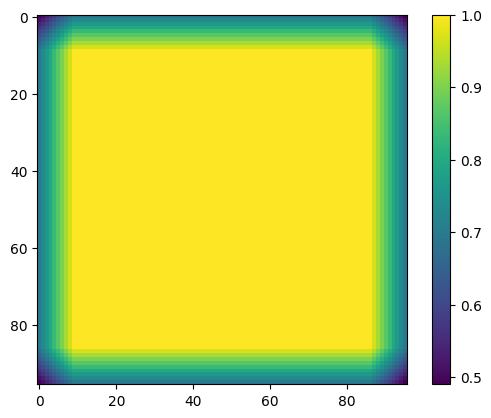

In [15]:
def create_3d_weight_array(patch_size, margin):
    """
    Creates a 3D weight array for patch-based processing with linear weight transitions
    in overlapping regions.
    
    Args:
        patch_size: Tuple of (depth, height, width) for the patch
        margin: Tuple of (d_margin, h_margin, w_margin) for overlap regions
        
    Returns:
        3D numpy array of weights with shape patch_size
    """
    D, H, W = patch_size
    d_margin, h_margin, w_margin = margin
    
    # Initialize the weight array with ones
    weights = np.ones((D, H, W), dtype=np.float32)
    
    # Create linear ramps for each dimension
    d_ramp = np.linspace(0.7, 1, d_margin)
    h_ramp = np.linspace(0.7, 1, h_margin)
    w_ramp = np.linspace(0.7, 1, w_margin)
    
    # Apply depth transitions
    weights[:d_margin,:,:] *= d_ramp[:, None, None]
    weights[-d_margin:,:,:] *= d_ramp[::-1, None, None]
    
    # Apply height transitions
    weights[:, :h_margin,:] *= h_ramp[None, :, None]
    weights[:, -h_margin:,:] *= h_ramp[None, ::-1, None]
    
    # Apply width transitions
    weights[:, :, :w_margin] *= w_ramp[None, None, :]
    weights[:, :, -w_margin:] *= w_ramp[None, None, ::-1]
    
    return weights

weight = create_3d_weight_array([96,96,96],[12,10,10])
plt.imshow(weight[40,:,:])
plt.colorbar()

In [16]:
import os
PATH = '/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/'
SAMPLES = [
    x for x in os.listdir(PATH)
]

In [17]:
SAMPLES

['TS_6_4', 'TS_5_4', 'TS_69_2']

In [18]:
import zarr
def read_one_data(id, static_dir):
    zarr_dir = f'{static_dir}/{id}/VoxelSpacing10.000'
    zarr_file = f'{zarr_dir}/denoised.zarr'
    zarr_data = zarr.open(zarr_file, mode='r')
    volume = zarr_data[0][:]
    min_value = np.percentile(volume.flatten(), 0.15)
    max_value = np.percentile(volume.flatten(), 98)
    image = (volume - min_value) / (max_value - min_value)    
    image = np.clip(image, 0, 1)
    return volume


In [19]:
import cc3d
from scipy.ndimage import binary_erosion, generate_binary_structure, iterate_structure

def create_3d_disc(radius=2):
    # Start with a basic 3D connectivity structure
    # connectivity=1 gives 6-connectivity (face neighbors)
    # connectivity=2 gives 18-connectivity (face and edge neighbors)
    # connectivity=3 gives 26-connectivity (face, edge, and vertex neighbors)
    basic_structure = generate_binary_structure(3, 2)
    
    # Iterate the structure to create a disc shape
    # iterations=radius-1 because generate_binary_structure creates a 3x3x3 structure
    disc = iterate_structure(basic_structure, radius-1)
    
    return disc
    
def run_submit(experiments):
    df = []
    experiment, particle_type, x, y, z = [], [] ,[] ,[] ,[]
    
    for i, id in enumerate(experiments):
        print(i, id, '---------------')
        volume = read_one_data(id, static_dir=f'/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns')
        print(volume.shape)
        
        # Extract patches with minimal overlap
        patches_volume, coordinates = extract_3d_patches_minimal_overlap([volume], 96)
        D, H, W = volume.shape
        
        # Initialize arrays for accumulating predictions
        probability = np.zeros((7, D, H, W), dtype=np.float32)
        count = np.zeros((7, D, H, W), dtype=np.float32)
        n_per_batch = 5
        count_coordinates = 0
        
        for j in range(0, len(patches_volume), n_per_batch):
            with torch.no_grad():
                input_patches = patches_volume[j:j+n_per_batch]
                input_patches = np.expand_dims(input_patches, axis=1)
                
                # Create both original and rotated versions of the patches
                input_orig = torch.from_numpy(input_patches).float()
                input_rot = torch.rot90(input_orig, k=1, dims=(3, 4))# Rotate in the spatial dimensions
                
                # Stack them in the batch dimension
                input_combined = torch.cat([input_orig, input_rot], dim=0).to(device)

                
                # Get predictions for both original and rotated patches
                predictions_combined = model(input_combined)
                predictions_combined = torch.nn.functional.softmax(predictions_combined, dim=1)

                
                # Split predictions back into original and rotated
                n_patches = len(input_patches)
                pred_orig = predictions_combined[:n_patches]
                pred_rot = predictions_combined[n_patches:]
                
                # Rotate back the rotated predictions
                pred_rot = torch.rot90(pred_rot, k=-1, dims=(3, 4))
                
                # Average the predictions
                predictions = (pred_orig + pred_rot) / 2
                predictions = predictions.cpu()
                
                # Clear GPU memory
                torch.cuda.empty_cache()
                gc.collect()
                
                # Accumulate weighted predictions
                for prediction in predictions:
                    left_point = coordinates[count_coordinates]                    
                    # Add weighted predictions to the appropriate location
                    probability[:, 
                              left_point[0]:96+left_point[0],
                              left_point[1]:left_point[1]+96,
                              left_point[2]:left_point[2]+96] = prediction * weight
                    
                    count[:, 
                          left_point[0]:96+left_point[0],
                          left_point[1]:left_point[1]+96,
                          left_point[2]:left_point[2]+96] += weight
                    
                    count_coordinates += 1
                    
        # Average the probabilities using the accumulated weights
        probability_maps = probability / (count + 0.0001)
        structure = create_3d_disc(radius=1)  # Adjust radius as needed
        particles = [1,2,3,4,5,6]
        names = ['apo-ferritin', "beta-amylase", 'beta-galactosidase','ribosome','thyroglobulin','virus-like-particle']
        radius = [6,6.5,9,15,13,13.5]
        for idx in particles:
        
            # Get probability map for this particle type and apply threshold
            prob_map = probability_maps[idx,:,:,:]
            binary_mask = prob_map > 0.05
            
            binary_mask = binary_erosion(binary_mask, structure=structure, iterations=2)

            # Find connected components
            labels = cc3d.connected_components(binary_mask)
            stats = cc3d.statistics(labels)
            
            # Get volumes of all components (excluding background)
            volumes = stats["voxel_counts"][1:]  # Exclude background (label 0)
            
            # Calculate volume threshold
            sphere_volume = (4 / 3) * np.pi * ((radius[idx-1] * 0.8) ** 3)
            
            # Filter components based on volume threshold
            valid_indices = [i for i, v in enumerate(volumes) if v >= sphere_volume * 0.25]
            
            if not valid_indices:
                continue
            
            # Get centroids for valid components
            centroids = stats['centroids'][1:]  # Skip background (label 0)
            valid_centroids = centroids[valid_indices]  # Select only valid centroids
            
            if len(valid_centroids) > 0:
                # Scale coordinates by voxel size (10nm in your case)
                scaled_centroids = 10 * valid_centroids  # Adjust for voxel size
                
                # Add to lists
                n_particles = len(valid_centroids)
                experiment.extend([id] * n_particles)
                particle_type.extend([names[idx-1]] * n_particles)
                x.extend(scaled_centroids[:, 2])  # ZYX to XYZ conversion
                y.extend(scaled_centroids[:, 1])
                z.extend(scaled_centroids[:, 0])
            
    return experiment, particle_type, x, y, z

experiment, particle_type, x, y, z = run_submit(SAMPLES)

0 TS_6_4 ---------------
(184, 630, 630)
8.0
7.0
7.0
1 TS_5_4 ---------------
(184, 630, 630)
8.0
7.0
7.0
2 TS_69_2 ---------------
(184, 630, 630)
8.0
7.0
7.0


In [21]:
pd.DataFrame({
    'id':np.arange(len(experiment)),
    'experiment':experiment,
    'particle_type':particle_type,
    'x':x,
    'y':y,
    'z':z
}).to_csv('submission.csv',index=False)

In [62]:
path_to_overlay = "/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns"
import json
names = ['apo-ferritin', "beta-amylase", 'beta-galactosidase','ribosome','thyroglobulin','virus-like-particle']
experiments =[]
particle_names= []
x_particles=[]
y_particles=[]
z_particles=[]

for i,id in enumerate(SAMPLES):
    file = path_to_overlay+f"/{id}/Picks/"
    for particle_name in names:
        file_name = file + particle_name + ".json"
        with open(file_name,"r") as f:
            data = json.load(f)
        data = data["points"]
        x = [d["location"]["x"] for d in data]
        y = [d["location"]["y"] for d in data]
        z = [d["location"]["z"] for d in data]
        experiments.extend([id]*len(x))
        particle_names.extend([particle_name]*len(x))
        x_particles.extend(x)
        y_particles.extend(y)
        z_particles.extend(z)

    
    

In [63]:
pd.DataFrame({
    'id':np.arange(len(experiments)),
    'experiment':experiments,
    'particle_type':particle_names,
    'x':x_particles,
    'y':y_particles,
    'z':z_particles
}).to_csv('check_sub.csv',index=False)

### 